In [12]:
%matplotlib inline

import fipy as fp
from fipy.tools.dump import read
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as p
from fvm_utils import *

In [13]:
fipyFolder = "./data/Georgia_Fulton_small/fipy_output"
fipyFiles = sorted(glob(os.path.join(fipyFolder, "*.fipy")))

Each element of `fipyFiles` contains information for a given time point. Here, we will load a single time point

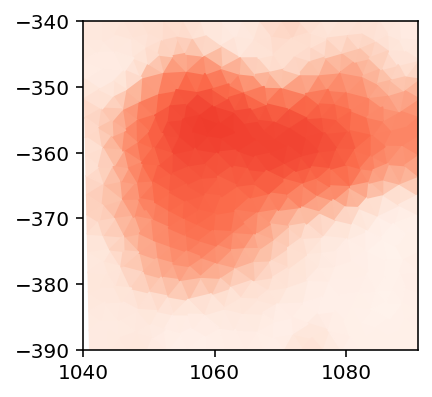

In [14]:
fig, ax = plt.subplots(dpi=144, figsize=(3, 3))
for file in fipyFiles[100:101]:
    ϕW, ϕB, t = read(file)
    plot_mesh(ϕB, ϕB.mesh, ax,
              cmap=plt.cm.Reds,
              vmin=0, vmax=1)
    

In [15]:
all_gradients, sociohydro_gradients = calc_gradients(ϕW, ϕB)

The variable `all_gradients` contains all scalar valued combinations of up to 4 gradients of two fields, $\phi_W$ and $\phi_B$, in the following order:
$$
\text{all\_gradients} = 
\begin{pmatrix}
    \nabla^2 \phi_W \\
    \nabla^4 \phi_W \\
    \nabla^2 \phi_B \\
    \nabla^4 \phi_B \\
    \nabla \phi_W \cdot \nabla \phi_W \\
    \nabla \phi_B \cdot \nabla \phi_B \\
    \nabla \phi_W \cdot \nabla \phi_B \\
    \nabla \phi_W \cdot \nabla^3 \phi_W \\
    \nabla \phi_W \cdot \nabla^3 \phi_B \\
    \nabla \phi_B \cdot \nabla^3 \phi_W \\
    \nabla \phi_B \cdot \nabla^3 \phi_B
\end{pmatrix}
$$

In [16]:
[ϕW_lap,
ϕW_bilap,
ϕB_lap,
ϕB_bilap,
ϕW_grad_ϕW_grad,
ϕB_grad_ϕB_grad,
ϕW_grad_ϕB_grad,
ϕW_grad_ϕW_gradlap,
ϕW_grad_ϕB_gradlap,
ϕB_grad_ϕW_gradlap,
ϕB_grad_ϕB_gradlap] = all_gradients

In [17]:
# calculate vector gradients just to see them
ϕW_grad = ϕW.grad
ϕW_lap_grad = ϕW_lap.grad

ϕB_grad = ϕB.grad
ϕB_lap_grad = ϕB_lap.grad

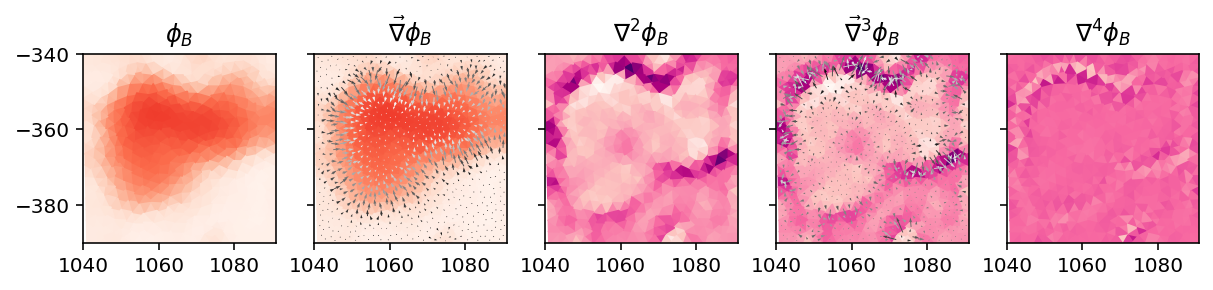

In [18]:
fig, ax = plt.subplots(1, 5, dpi=144, figsize=(10, 2), sharey=True)

# original field
plot_mesh(ϕB, ϕB.mesh, ax[0], cmap=plt.cm.Reds,
          vmin=0, vmax=1)
ax[0].set(title=r"$\phi_B$")

# plot gradient
x, y = ϕB_grad.mesh.cellCenters.value
u, v = ϕB_grad.value
plot_mesh(ϕB, ϕB.mesh, ax[1], cmap=plt.cm.Reds,
          vmin=0, vmax=1)
ax[1].quiver(x, y, u, v, ϕB.value, cmap="Greys_r", width=5e-3)
ax[1].set(title=r"$\vec{\nabla} \phi_B$")

# plot laplacian
plot_mesh(ϕB_lap, ϕB_lap.mesh, ax[2], cmap=plt.cm.RdPu)
ax[2].set(title=r"$\nabla^2 \phi_B$")

# plot gradient of laplacian
x, y = ϕB_lap_grad.mesh.cellCenters.value
u, v = ϕB_lap_grad.value
plot_mesh(ϕB_lap, ϕB_lap.mesh, ax[3], cmap=plt.cm.RdPu)
ax[3].quiver(x, y, u, v, ϕB_lap.value, cmap="Greys_r", width=5e-3)
ax[3].set(title=r"$\vec{\nabla}^3 \phi_B$")

# plot bilaplacian
plot_mesh(ϕB_bilap, ϕB_bilap.mesh, ax[4],
          cmap=plt.cm.RdPu, vmin=-0.1, vmax=0.1)
ax[4].set(title=r"$\nabla^4 \phi_B$")

for a in ax.ravel():
    a.set_aspect(1)

The variable `sociohydro_gradients` is a length 2 list that combines the gradients as they appear in the sociohydrodynamic equations, to aid in parameter inference.

For reference, the sociohydrodynamic equations are:
$$
\partial_t \phi_i = T_i \left( \phi_0 \nabla^2 \phi_i - \phi_i \nabla^2 \phi_0 \right) - \nabla \cdot \left( \phi_0 \phi_i \left(\nabla \pi_i + \Gamma_i \nabla^3 \phi_i \right) \right)
$$
where $\phi_0 = 1 - \phi_1 - \phi_2$ is the vacancy fraction, $T_i$ is a temperature (diffusion constant) and $\Gamma_i$ is a surface tension.

In our simulations, we use a utility function $\pi_i(\vec{\phi})$ given by generic quadratic function:
$$\pi_i(\vec{\phi}) = \sum_j k_{ij} \phi_j + \sum_{jk} \nu_{ijk} \phi_j \phi_k$$

Given the input `calc_gradients(var1, var2)`, `sociohydro_gradients[0]` gives the coefficients for the population represented by `var1`, and `sociohydro_gradients[1]` gives the coefficients for the population represented by `var2`. Each of these lists is given by:
```
sociohydro_gradients[i] = 
[
    Ti_term,
    kii_term,
    kij_term,
    nuiii_term,
    nuiij_term,
    νijj_term,
    Γi_term
]
```
where
$$
\begin{align}
T_i &= \phi_0 \nabla^2 \phi_i - \phi_i \nabla^2 \phi_0 \\
k_{ij} &= \nabla \cdot \left( \phi_0 \phi_i \nabla \phi_j \right) \\
\nu_{ijk} &= \nabla \cdot \left( \phi_0 \phi_i \nabla \left(\phi_j \phi_k \right) \right) \\
\Gamma_i &= \nabla \cdot \left( \phi_0 \phi_i \nabla^3 \phi_j \right)
\end{align}
$$

The true values of the parameters used in the simulation are given here

In [19]:
paramfile = "./data/2024-07-22_coefficients_allFeatures_trainPct0.7_sigma2.0_NewYork_NYC_mean.csv"
params = pd.read_csv(paramfile)
params

,name,demo,val
0,$T_i$,B,1.718363
1,$T_i$,W,0.375554
2,$\Gamma_i$,B,-5.232607
3,$\Gamma_i$,W,-2.461651
4,$\nu_{iii}$,B,32.692297
5,$\nu_{iii}$,W,6.400740
6,$\nu_{iij}$,B,-3.846849
7,$\nu_{iij}$,W,18.906208
8,$\nu_{ijj}$,B,-9.856063
9,$\nu_{ijj}$,W,18.608736


In [20]:
[TW_term,
 kWW_term,
 kWB_term,
 νWWW_term,
 νWWB_term,
 νWBB_term,
 ΓW_term] = sociohydro_gradients[0]

[TB_term,
 kBB_term,
 kBW_term,
 νBBB_term,
 νBWB_term,
 νBWW_term,
 ΓB_term] = sociohydro_gradients[1]

In [21]:
TW, ΓW, νWWW, νWWB, νWBB, kWW, kWB = params[params["demo"]=="W"].val.values
TB, ΓB, νBBB, νBWB, νBWW, kBB, kBW = params[params["demo"]=="B"].val.values

The true time derivatives should then be approximated as follows (note the minus signs):

In [22]:
dϕW_dt =(TW * TW_term -
         kWW * kWW_term -
         kWB * kWB_term -
         νWWW * νWWW_term -
         νWWB * νWWB_term -
         νWBB * νWBB_term -
         ΓW * ΓW_term)

dϕB_dt =(TB * TB_term -
         kBW * kBW_term -
         kBB * kBB_term -
         νBWW * νBWW_term -
         νBWB * νBWB_term -
         νBBB * νBBB_term -
         ΓB * ΓB_term)

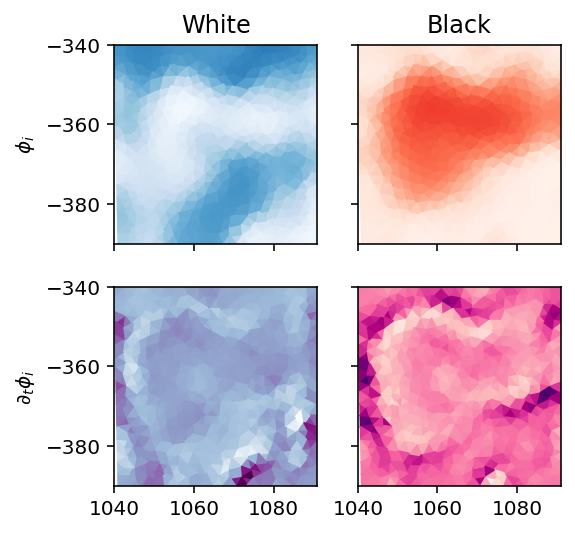

In [23]:
fig, ax = plt.subplots(2, 2, sharey=True, sharex=True, dpi=144, figsize=(4, 4))
plot_mesh(ϕW, ϕW.mesh, ax[0, 0],
          cmap=plt.cm.Blues, vmin=0, vmax=1)
plot_mesh(ϕB, ϕB.mesh, ax[0, 1],
          cmap=plt.cm.Reds, vmin=0, vmax=1)

plot_mesh(dϕW_dt, dϕW_dt.mesh, ax[1, 0], cmap=plt.cm.BuPu)
plot_mesh(dϕB_dt, dϕB_dt.mesh, ax[1, 1], cmap=plt.cm.RdPu)

ax[0, 0].set(title="White", ylabel=r"$\phi_i$")
ax[0, 1].set(title="Black")
ax[1, 0].set(ylabel=r"$\partial_t \phi_i$")

for a in ax.ravel():
    a.set_aspect(1)


In addition, the simulations used the growth terms $r \phi_i$, with the growth rates $r$ given in the following

In [24]:
growthfile = "./data/2024-08-07_fillFractionGrowthRates.csv"
growth = pd.read_csv(growthfile)
growth

,state,county,growthW,growthB
0,California,Los Angeles,-0.003005,0.008707
1,Georgia,Fulton,0.007017,0.018329
2,Illinois,Cook,-0.009791,0.009451
3,Michigan,Wayne,-0.006920,0.003198
4,New York,Kings,-0.005369,0.003687
5,Texas,Harris,0.001789,0.026798


Here, since we are simulating Fulton County Georgia, we used the values in row 1 of the above table

In [31]:
import h5py

with h5py.File('./data/Georgia_Fulton_small/Georgia_Fulton_small_NYCinferredParams.hdf5', 'r') as h5f:
    print(list(h5f.keys()))
    print(h5f['common'].keys())
    print(h5f['common/phiB_final'])
    print(h5f['n000001'].keys())
    print(h5f['n000001/phiB'])


['common', 'n000001', 'n000002', 'n000003', 'n000004', 'n000005', 'n000006', 'n000007', 'n000008', 'n000009', 'n000010', 'n000011', 'n000012', 'n000013', 'n000014', 'n000015', 'n000016', 'n000017', 'n000018', 'n000019', 'n000020', 'n000021', 'n000022', 'n000023', 'n000024', 'n000025', 'n000026', 'n000027', 'n000028', 'n000029', 'n000030', 'n000031', 'n000032', 'n000033', 'n000034', 'n000035', 'n000036', 'n000037', 'n000038', 'n000039', 'n000040', 'n000041', 'n000042', 'n000043', 'n000044', 'n000045', 'n000046', 'n000047', 'n000048', 'n000049', 'n000050', 'n000051', 'n000052', 'n000053', 'n000054', 'n000055', 'n000056', 'n000057', 'n000058', 'n000059', 'n000060', 'n000061', 'n000062', 'n000063', 'n000064', 'n000065', 'n000066', 'n000067', 'n000068', 'n000069', 'n000070', 'n000071', 'n000072', 'n000073', 'n000074', 'n000075', 'n000076', 'n000077', 'n000078', 'n000079', 'n000080', 'n000081', 'n000082', 'n000083', 'n000084', 'n000085', 'n000086', 'n000087', 'n000088', 'n000089', 'n000090',